In [1]:
import pandas as pd
import numpy as np
import csv

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Summary

The main purpose of this notebook is to create DONOR x MARKETING ATTRIBUTE matrix. <br>
The value in each cell would be the particular value of Marketing Attribute for a DONOR (using ATZHL, see below). <br>
This matrix can be used a features for classifying donors who donate only once to Leuven University Fund (LUF) and donors who donate more than once to LUF. <br>

A marketing attribute is a property of a business partner. 'Number of children' is an example for the marketing attribute. <br> 

There are 32 marketing attributes that is defined in the LUF database. Among them, 30 marketing attributes are filled. <br>

We use six tables to create DONOR x MARKETING ATTRIBUTE matrix, namely <b>BUT00</b>, <b>AUSP</b>, <b>CABN</b>, <b>CABNT</b>, <b>CAWN</b> and <b>CAWNT</b>. <br>
These tables are connected as shown in the data model below: <br>
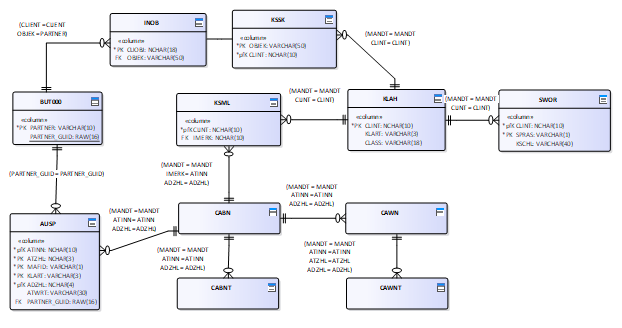

BUT000 is the main table that contain information about various business partners of LUF. In this notebook we only use the PARTNER id feature of BUT000 table. <br>

AUSP contains the values of a business partner marketing attributes. A marketing attribute is a characteristic of a business partner. Since marketing attributes provide a very flexible structure, they are used to store all kinds of business partner information.<br>
The features for AUSP table are: <br>
-  ADZHL    - Mainly used as a join key to KSML, CABN, CABNT, CAWN, CAWNT, & AUSP
-  ATINN    - Mainly used as a join key to CABN, CABNT, CAWN, CAWNT, & AUSP
-  ATWRT    - Technical value of a marketing attribute
-  ATZHL    - ATZHL is the numeric mapping of ATWRT 
-  KLART    - All 1579417 entries are 'BUP'
-  MAFID    - All 1579417 entries are 'O'

CABN contains the definition of marketing attributes, e.g. hobby, number of children etc. <br>
The features for CABN table are: <br>
-  ADZHL    - Mainly used as a join key between AUSP, CABNT, and CAWN
-  ATEIN    - 'X' means marketing attribute is not multivalued (23 out of 32 ma's have X)
-  ATNAM    - Char ID of the marketing attribute
-  ATFOR    - Datatype of marketing attribute only 1 out of 32 has datatype of 'DATE', rest is 'CHAR'
-  ATNAM    - ID of the marketing attribute. Eg ZLUF_AANTAL_KINDEREN is the id for 'Number of children' marketing attribute

CABNT contains the translations of the names of the marketing attributes. <br>
The features for CABNT table are: <br>
-  ADZHL    - Mainly used as a join key to CABN
-  ATINN    - Mainly used as a join key to CABN
-  ATBEZ    - Has both English & Nederlands description of marketing attribute based on if SPRAS = 'E' or 'N'
-  ATUE1    - Is the continuation of description of ATBEZ on cases where len(ATBEZ) exceeds maximum specified length
-  SPRAS    - Language (E - English, N - Netherlands)

CAWN contains the definition of the possible values of marketing attributes for attributes whose value is to be selected from a dropdown list. <br>
The features for CAWN table are: <br>
-  ADZHL    - Mainly used as a join key to CABN and CAWNT
-  ATINN    - Mainly used as a join key to CABN and CAWNT
-  ATWRT    - Technical value of a marketing attribute
-  ATZHL    - ATZHL is the numeric mapping of ATWRT

CAWNT contains the translations of the possible values of the marketing attributes.
The features for CAWNT table are: <br>
-  ADZHL        - Mainly used as a join key to CAWN
-  ATINN        - Mainly used as a join key to CAWN
-  ATVALUEDESCR - Description of a possible value of a marketing attribute
-  ATWTB        - Shorter description of ATVALUEDESCR
-  ATZHL        - ATZHL is the numeric mapping of ATWRT
-  SPRAS        - Language (E - English, N - Netherlands)


We only keep the marketing attributes which are represented by at least 100 donors, otherwise we cannot use them as features for the classifier.

In [3]:
ausp = pd.read_csv('sqldata/20190102_AUSP.csv',dtype = str, encoding='latin-1',sep=';')
print(ausp.shape)
ausp.head()

(1579417, 8)


,ADZHL,ATINN,ATWRT,ATZHL,KLART,MAFID,OBJEK,PARTNER_GUID
0,0000,0000000252,0,001,BUP,O,000000000001072101,0050569479351ED897FFAE9162423E47
1,0000,0000000252,0,001,BUP,O,000000000001093297,0050569479351EE8B0AB5F7ADF28CB3D
2,0000,0000000252,0,001,BUP,O,000000000001071707,2294EB49A90B1EE68FD50FEA92B20763
3,0000,0000000252,0,001,BUP,O,000000000001072720,0050569479351ED89BC3819E16162C8D
4,0000,0000000252,0,001,BUP,O,000000000001072721,0050569479351ED89BC381A2BDC06C8D


In [4]:
but000 = pd.read_csv('sqldata/20190102_BUT000.csv',dtype = str, encoding='latin-1',sep=';')

In [5]:
cabn = pd.read_csv('sqldata/20190102_CABN.csv',dtype = str, encoding='latin-1',sep=';')
print(cabn.shape)
cabn.head()

(32, 5)


,ADZHL,ATEIN,ATFOR,ATINN,ATNAM
0,0000,X,CHAR,0000000236,ZLUF_AANTAL_KINDEREN
1,0000,NaN,CHAR,0000000237,ZLUF_LIJST
2,0000,NaN,CHAR,0000000238,ZLUF_GEZINSSAMENSTELLING
3,0000,X,CHAR,0000000239,ZLUF_COMM_CAMPAGNE
4,0000,X,CHAR,0000000240,ZLUF_COMM_DANKBRIEF


In [6]:
cabnt = pd.read_csv('sqldata/20190102_CABNT.csv',dtype = str, encoding='latin-1',sep=';')
print(cabnt.shape)
cabnt.head()

(61, 5)


,ADZHL,ATBEZ,ATINN,ATUE1,SPRAS
0,0000,Number of Children,0000000236,NaN,E
1,0000,Aantal kinderen,0000000236,NaN,N
2,0000,Belongs to list,0000000237,NaN,E
3,0000,Behoort tot lijst,0000000237,NaN,N
4,0000,Bijzondere gezinssamenstelling,0000000238,NaN,N


In [7]:
cawn = pd.read_csv('sqldata/20190102_CAWN.csv',dtype = str, encoding='latin-1',sep=';')
print(cawn.shape)
cawn.head()

(225, 4)


,ADZHL,ATINN,ATWRT,ATZHL
0,0000,0000000236,0,0001
1,0000,0000000236,1,0002
2,0000,0000000236,2,0003
3,0000,0000000236,3,0004
4,0000,0000000236,4,0005


In [8]:
cawnt = pd.read_csv('sqldata/20190102_CAWNT.csv',dtype = str, encoding='latin-1',sep=';')
print(cawnt.shape)
cawnt.head()

(309, 6)


,ADZHL,ATINN,ATVALUEDESCR,ATWTB,ATZHL,SPRAS
0,0000,0000000236,0,0,0001,E
1,0000,0000000236,0,0,0001,N
2,0000,0000000236,1,1,0002,E
3,0000,0000000236,1,1,0002,N
4,0000,0000000236,2,2,0003,E


In [9]:
ausp_trim = ausp[['PARTNER_GUID','ATINN','ATWRT']]
print(ausp_trim.shape)

(1579417, 3)


In [10]:
but000_trim = but000[['PARTNER','PARTNER_GUID']]
print(but000_trim.shape)

(72114, 2)


In [11]:
#Merge the trimmed AUSP table with trimmed BUT000 table and store the result in ausp_trip
ausp_trim = pd.merge(ausp_trim,but000_trim,on='PARTNER_GUID',how='inner')
ausp_trim = ausp_trim[['PARTNER','PARTNER_GUID','ATINN','ATWRT']]
ausp_trim.head()

,PARTNER,PARTNER_GUID,ATINN,ATWRT
0,0201289954,0050569479351ED897FFAE9162423E47,0000000252,0
1,0201289954,0050569479351ED897FFAE9162423E47,0000000247,1
2,0201289954,0050569479351ED897FFAE9162423E47,0000000246,1
3,0201289954,0050569479351ED897FFAE9162423E47,0000000245,1
4,0201289954,0050569479351ED897FFAE9162423E47,0000000244,1


In [12]:
#First select only cabnt values where Language (SPRAS) is 'N'. Then join cabnt_n with cabn
cabnt_n = cabnt[cabnt['SPRAS']=='N'].reset_index(drop=True)
cabnt_n = cabnt_n[['ADZHL','ATINN','ATBEZ','ATUE1','SPRAS']]
cabnt_n['ATUE1'] = cabnt_n['ATUE1'].fillna('') #Replace NaN value in ATUE1 with blank. Useful for concatenating ATBEZ+ATUE1
cabn_merge = pd.merge(cabn,cabnt_n,how='inner',on=['ATINN','ADZHL'])
print(cabn_merge.shape)
cabn_merge.head()

(32, 8)


,ADZHL,ATEIN,ATFOR,ATINN,ATNAM,ATBEZ,ATUE1,SPRAS
0,0000,X,CHAR,0000000236,ZLUF_AANTAL_KINDEREN,Aantal kinderen,,N
1,0000,NaN,CHAR,0000000237,ZLUF_LIJST,Behoort tot lijst,,N
2,0000,NaN,CHAR,0000000238,ZLUF_GEZINSSAMENSTELLING,Bijzondere gezinssamenstelling,,N
3,0000,X,CHAR,0000000239,ZLUF_COMM_CAMPAGNE,Comm. - Campagne,,N
4,0000,X,CHAR,0000000240,ZLUF_COMM_DANKBRIEF,Comm. - Dankbrief bij elke sch,enking,N


In [13]:
#First select only cawnt values where Language (SPRAS) is 'N'. Then join cawnt_n with cawn
cawnt_n = cawnt[cawnt['SPRAS']=='N'].reset_index(drop=True)
cawn_merge = pd.merge(cawn,cawnt_n,how='inner',on=['ATINN','ATZHL','ADZHL'])
print(cawn_merge.shape)
cawn_merge.head()

(225, 7)


,ADZHL,ATINN,ATWRT,ATZHL,ATVALUEDESCR,ATWTB,SPRAS
0,0000,0000000236,0,0001,0,0,N
1,0000,0000000236,1,0002,1,1,N
2,0000,0000000236,2,0003,2,2,N
3,0000,0000000236,3,0004,3,3,N
4,0000,0000000236,4,0005,4,4,N


In [14]:
#merge CABN/T tables with CAWN/T tables
cabn_cawn_merge = pd.merge(cabn_merge,cawn_merge,how='inner',on=['ATINN','ADZHL'])
print(cabn_cawn_merge.shape)
cabn_cawn_merge.head()

(225, 13)


,ADZHL,ATEIN,ATFOR,ATINN,ATNAM,ATBEZ,ATUE1,SPRAS_x,ATWRT,ATZHL,ATVALUEDESCR,ATWTB,SPRAS_y
0,0000,X,CHAR,0000000236,ZLUF_AANTAL_KINDEREN,Aantal kinderen,,N,0,0001,0,0,N
1,0000,X,CHAR,0000000236,ZLUF_AANTAL_KINDEREN,Aantal kinderen,,N,1,0002,1,1,N
2,0000,X,CHAR,0000000236,ZLUF_AANTAL_KINDEREN,Aantal kinderen,,N,2,0003,2,2,N
3,0000,X,CHAR,0000000236,ZLUF_AANTAL_KINDEREN,Aantal kinderen,,N,3,0004,3,3,N
4,0000,X,CHAR,0000000236,ZLUF_AANTAL_KINDEREN,Aantal kinderen,,N,4,0005,4,4,N


Description of marketing attributes is shown below

In [15]:
ma_desc = cabn_cawn_merge[['ATINN','ATNAM','ATBEZ','ATUE1','ATWRT','ATZHL','ATVALUEDESCR']]
ma_desc['ATBEZ'] = ma_desc['ATBEZ'] + ma_desc['ATUE1']
ma_desc = ma_desc[['ATNAM','ATBEZ']]
ma_desc = ma_desc.drop_duplicates()
ma_desc.reset_index(drop=True,inplace=True)
#ma_desc.to_csv('SQLDATA/PYTHON_OUTPUTS/marketing_attributes_description.csv') #Save if needed
ma_desc


,ATNAM,ATBEZ
0,ZLUF_AANTAL_KINDEREN,Aantal kinderen
1,ZLUF_LIJST,Behoort tot lijst
2,ZLUF_GEZINSSAMENSTELLING,Bijzondere gezinssamenstelling
3,ZLUF_COMM_CAMPAGNE,Comm. - Campagne
4,ZLUF_COMM_DANKBRIEF,Comm. - Dankbrief bij elke schenking
5,ZLUF_COMM_FISCAALATTEST,Comm. - Fiscaal attest
6,ZLUF_COMM_JAARVERSLAG,Comm. - Jaarverslag LUF
7,ZLUF_COMM_KERSTKAART,Comm. - Kerstkaart
8,ZLUF_COMM_MAILINGS,Comm. - Mailings LUF
9,ZLUF_COMM_NB,Comm. - Nieuwsbrief LUF


In [16]:
ma = pd.merge(ausp_trim,cabn_cawn_merge,how='inner',on=['ATINN','ATWRT'])
print(ma.shape)
ma.head()

(1577172, 15)


,PARTNER,PARTNER_GUID,ATINN,ATWRT,ADZHL,ATEIN,ATFOR,ATNAM,ATBEZ,ATUE1,SPRAS_x,ATZHL,ATVALUEDESCR,ATWTB,SPRAS_y
0,0201289954,0050569479351ED897FFAE9162423E47,0000000252,0,0000,X,CHAR,ZLUF_RECURRENT,Recurrente schenker,,N,0001,Nee,Nee,N
1,0201306946,0050569479351EE8B0AB5F7ADF28CB3D,0000000252,0,0000,X,CHAR,ZLUF_RECURRENT,Recurrente schenker,,N,0001,Nee,Nee,N
2,0201111273,2294EB49A90B1EE68FD50FEA92B20763,0000000252,0,0000,X,CHAR,ZLUF_RECURRENT,Recurrente schenker,,N,0001,Nee,Nee,N
3,0201291343,0050569479351ED89BC3819E16162C8D,0000000252,0,0000,X,CHAR,ZLUF_RECURRENT,Recurrente schenker,,N,0001,Nee,Nee,N
4,0201291344,0050569479351ED89BC381A2BDC06C8D,0000000252,0,0000,X,CHAR,ZLUF_RECURRENT,Recurrente schenker,,N,0001,Nee,Nee,N


In [17]:
ma_trim = ma[['PARTNER','ATNAM','ATZHL']]
ma_trim['ATZHL'] = ma_trim['ATZHL'].astype('int32')
ma_trim.tail()

,PARTNER,ATNAM,ATZHL
1577167,0201286201,ZLUF_COMM_KERSTKAART,3
1577168,0201063265,ZLUF_COMM_KERSTKAART,3
1577169,0201063265,ZLUF_COMM_EVENEMENT,3
1577170,0201063265,ZLUF_COMM_VERJAARDAG,3
1577171,0201303114,ZLUF_ADEL,8


There are many marketing attributes (ATNAM) that doesn't offer any information to the classifier meaning that majority of the values are unknown, missing, or conatining only one major value. <br>
Such marketing attributes are filtered in the below cell. <br>
There are some marketing attributes that are multi-valued. Such attributes are separated into different features.

In [18]:
#Only 4 values out of ZLUF_AANTAL_KINDEREN are known, better delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_AANTAL_KINDEREN'] #This operation deletes data where ATNAM = ZLUF_AANTAL_KINDEREN

ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_LIJST'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_LIJST'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 1)

#Almost all ZLUF_GEZINSSAMENSTELLING values are 1. No info from this. Delete this
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_GEZINSSAMENSTELLING'] #This operation deletes data where ATNAM = ZLUF_GEZINSSAMENSTELLING

#Almost all ZLUF_COMM_CAMPAGNE values are 1. No info from this. Delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_CAMPAGNE']  #This operation deletes data where ATNAM = ZLUF_COMM_CAMPAGNE

#Almost all ZLUF_COMM_DANKBRIEF values are 3. No info from this. Delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_DANKBRIEF']  #This operation deletes data where ATNAM = ZLUF_COMM_DANKBRIEF

#Almost all ZLUF_COMM_FISCAALATTEST values are 2. No info from this. Better delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_FISCAALATTEST']  #This operation deletes data where ATNAM = ZLUF_COMM_FISCAALATTEST

#Almost all ZLUF_COMM_JAARVERSLAG values are 1. No info from this. Better delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_JAARVERSLAG']  #This operation deletes data where ATNAM = ZLUF_COMM_JAARVERSLAG

#Almost all ZLUF_COMM_KERSTKAART values are 2. No info from this. Better delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_KERSTKAART']  #This operation deletes data where ATNAM = ZLUF_COMM_KERSTKAART

#Almost all ZLUF_COMM_MAILINGS values are 2. No info from this. Delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_MAILINGS']  #This operation deletes data where ATNAM = ZLUF_COMM_MAILINGS

#No info from ZLUF_COMM_NB. Delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_NB']  #This operation deletes data where ATNAM = ZLUF_COMM_NB

#Almost all ZLUF_COMM_ALG values are 2. No info from this. Better delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_ALG']  #This operation deletes data where ATNAM = ZLUF_COMM_ALG

#Almost all ZLUF_COMM_EVENEMENT values are 2. No info from this. Better delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_EVENEMENT']  #This operation deletes data where ATNAM = ZLUF_COMM_EVENEMENT

#Almost all ZLUF_COMM_VERJAARDAG values are 2. No info from this better delete this!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_COMM_VERJAARDAG']  #This operation deletes data where ATNAM = ZLUF_COMM_VERJAARDAG

ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_HOBBY'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_HOBBY'].replace([1,2,3,4,5,6,7,8,9,10,11,12], 1)#No entry for hobby anyway

#ZLUF_INTERESSELEGAAT is an interesting feature: 
    #1 No; 2 Yes, via notary; 3 Yes, via Testament.be; 4 Yes, the private individual has contacted LUF himself; 5 Yes, through family, prof, friends
#Remove ZLUF_INTERESSELEGAAT & replace it with 4 new features
ma_trim['ATNAM'][ma_trim['ATZHL']==2] = ma_trim['ATNAM'][ma_trim['ATZHL']==2].replace('ZLUF_INTERESSELEGAAT','ZLUF_INTERESSELEGAAT_NOTARY')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_INTERESSELEGAAT_NOTARY'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_INTERESSELEGAAT_NOTARY'].replace(2, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==3] = ma_trim['ATNAM'][ma_trim['ATZHL']==3].replace('ZLUF_INTERESSELEGAAT','ZLUF_INTERESSELEGAAT_TESTAMENTdotBE')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_INTERESSELEGAAT_TESTAMENTdotBE'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_INTERESSELEGAAT_TESTAMENTdotBE'].replace(3, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==4] = ma_trim['ATNAM'][ma_trim['ATZHL']==4].replace('ZLUF_INTERESSELEGAAT','ZLUF_INTERESSELEGAAT_REACHED_LUF')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_INTERESSELEGAAT_REACHED_LUF'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_INTERESSELEGAAT_REACHED_LUF'].replace(4, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==5] = ma_trim['ATNAM'][ma_trim['ATZHL']==5].replace('ZLUF_INTERESSELEGAAT','ZLUF_INTERESSELEGAAT_OTHER')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_INTERESSELEGAAT_OTHER'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_INTERESSELEGAAT_OTHER'].replace(5, 1)
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_INTERESSELEGAAT']  #Basically delete rows that contains ATZHL values of ZLUF_INTERESSELEGAAT == 1 

#ZLUF_SCHENKINTERESSE is an interesting feature: 12 different values. So create 8 binary features (4 other features have nil value) via new columns.
ma_trim['ATNAM'][ma_trim['ATZHL']==1] = ma_trim['ATNAM'][ma_trim['ATZHL']==1].replace('ZLUF_SCHENKINTERESSE','ZLUF_SCHENKINTERESSE_HEALTHCARE')
ma_trim['ATNAM'][ma_trim['ATZHL']==2] = ma_trim['ATNAM'][ma_trim['ATZHL']==2].replace('ZLUF_SCHENKINTERESSE','ZLUF_SCHENKINTERESSE_SPECIFICDISEASE')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_SPECIFICDISEASE'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_SPECIFICDISEASE'].replace(2, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==4] = ma_trim['ATNAM'][ma_trim['ATZHL']==4].replace('ZLUF_SCHENKINTERESSE','ZLUF_SCHENKINTERESSE_CHILDREN')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_CHILDREN'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_CHILDREN'].replace(4, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==5] = ma_trim['ATNAM'][ma_trim['ATZHL']==5].replace('ZLUF_SCHENKINTERESSE','ZLUF_SCHENKINTERESSE_SCHOLARSHIPS')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_SCHOLARSHIPS'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_SCHOLARSHIPS'].replace(5, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==6] = ma_trim['ATNAM'][ma_trim['ATZHL']==6].replace('ZLUF_SCHENKINTERESSE','ZLUF_SCHENKINTERESSE_HERITAGE')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_HERITAGE'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_HERITAGE'].replace(6, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==7] = ma_trim['ATNAM'][ma_trim['ATZHL']==7].replace('ZLUF_SCHENKINTERESSE','ZLUF_SCHENKINTERESSE_DEVCOOP')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_DEVCOOP'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_DEVCOOP'].replace(7, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==10] = ma_trim['ATNAM'][ma_trim['ATZHL']==10].replace('ZLUF_SCHENKINTERESSE','ZLUF_SCHENKINTERESSE_SOCIALSERVICE')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_SOCIALSERVICE'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_SOCIALSERVICE'].replace(10, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==12] = ma_trim['ATNAM'][ma_trim['ATZHL']==12].replace('ZLUF_SCHENKINTERESSE','ZLUF_SCHENKINTERESSE_ARTnCULTURE')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_ARTnCULTURE'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_SCHENKINTERESSE_ARTnCULTURE'].replace(12, 1)
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_SCHENKINTERESSE']  #This operation doesn't delete any data

#ZLUF_RECURRENT says if the donor is recurrent. I think I should delete this attribute. Otherwise data will be biased!
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_RECURRENT']  #This operation deletes data where ATNAM = ZLUF_RECURRENT

#ZLUF_RELIGIE all data is unknown (1). So a useless marketing attribute
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_RELIGIE']  #This operation deletes data where ATNAM = ZLUF_RELIGIE

#Less than 100 ZLUF_ADEL values are known, so better delete it
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_ADEL']  #This operation deletes data where ATNAM = ZLUF_ADEL

#ZLUF_AMBT gives some useful info as in if the donor title is a doctor, master(lawyer), notary etc.
    #So construct 3 additional features for titles like doctor, master(lawyer) and notary and delete rest of the entries
ma_trim['ATNAM'][ma_trim['ATZHL']==2] = ma_trim['ATNAM'][ma_trim['ATZHL']==2].replace('ZLUF_AMBT','ZLUF_AMBT_NOTARY')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_AMBT_NOTARY'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_AMBT_NOTARY'].replace(2, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==5] = ma_trim['ATNAM'][ma_trim['ATZHL']==5].replace('ZLUF_AMBT','ZLUF_AMBT_MASTERorLAWYER')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_AMBT_MASTERorLAWYER'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_AMBT_MASTERorLAWYER'].replace(5, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==9] = ma_trim['ATNAM'][ma_trim['ATZHL']==9].replace('ZLUF_AMBT','ZLUF_AMBT_DOCTOR')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_AMBT_DOCTOR'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_AMBT_DOCTOR'].replace(9, 1)
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_AMBT'] #This operation deletes entries where ATZHL values for ZLUF_AMBT is not 2,5 or 9

ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_KERKELIJK'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_KERKELIJK'].replace(1, 0)
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_KERKELIJK'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_KERKELIJK'].replace([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], 1)

ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_ORG_ALS_PERSOON'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_ORG_ALS_PERSOON'].replace(1, 0)
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_ORG_ALS_PERSOON'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_ORG_ALS_PERSOON'].replace(2, 1)

#ZLUF_ORG_SECTOR Most of them are Geen's. Only 13 of them is available. So better delete it
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_ORG_SECTOR']  #This operation deletes data where ATNAM = ZLUF_ORG_SECTOR

ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_ORG_VERENIGING'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_ORG_VERENIGING'].replace(1, 0)
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_ORG_VERENIGING'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_ORG_VERENIGING'].replace([2,3,4,5,6,7,8,9,10,11,12,13,14,15,
                                                                                                                               16,17,18,19,20,21], 1)

#ZLUF_CAMPAGNE is an interesting features that contains the campaigns done for donors, prospect etc
    #Replace this by 4 features, namely 1st campaign for board, relationships, donors, & partners.
ma_trim['ATNAM'][ma_trim['ATZHL']==1] = ma_trim['ATNAM'][ma_trim['ATZHL']==1].replace('ZLUF_CAMPAGNE','ZLUF_CAMPAGNE_BOARD')
ma_trim['ATNAM'][ma_trim['ATZHL']==3] = ma_trim['ATNAM'][ma_trim['ATZHL']==3].replace('ZLUF_CAMPAGNE','ZLUF_CAMPAGNE_PROSPECT')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_CAMPAGNE_PROSPECT'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_CAMPAGNE_PROSPECT'].replace(3, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==5] = ma_trim['ATNAM'][ma_trim['ATZHL']==5].replace('ZLUF_CAMPAGNE','ZLUF_CAMPAGNE_RELATIONSHIP')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_CAMPAGNE_RELATIONSHIP'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_CAMPAGNE_RELATIONSHIP'].replace(5, 1)
ma_trim['ATNAM'][ma_trim['ATZHL']==7] = ma_trim['ATNAM'][ma_trim['ATZHL']==7].replace('ZLUF_CAMPAGNE','ZLUF_CAMPAGNE_DONOR')
ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_CAMPAGNE_DONOR'] = ma_trim['ATZHL'][ma_trim['ATNAM']=='ZLUF_CAMPAGNE_DONOR'].replace(7,1)
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_CAMPAGNE']  #This operation doesn't delete any data

#ZLUF_VGS: Delete this as it contains less than 100 entries
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_VGS']  #This operation deletes data where ATNAM = ZLUF_VGS

#The below 5 marketing attributes say if the donors appear on donor list for specific funds. Better delete this features
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_SL_HS']  #This operation deletes data where ATNAM = ZLUF_SL_HS
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_SL_SCIENCE']  #This operation deletes data where ATNAM = ZLUF_SL_SCIENCE
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_SL_ZJDV']  #This operation deletes data where ATNAM = ZLUF_SL_ZJDV
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_SL_KULAK']  #This operation deletes data where ATNAM = ZLUF_SL_KULAK
ma_trim = ma_trim[ma_trim['ATNAM'] != 'ZLUF_SL_RD']  #This operation deletes data where ATNAM = ZLUF_SL_RD

In [19]:
marketing_attributes = pd.crosstab(index=ma_trim.iloc[:,0], columns=ma_trim.iloc[:,1], 
                  values=ma_trim.iloc[:,2],aggfunc='sum')
marketing_attributes['PARTNER'] = marketing_attributes.index
marketing_attributes.reset_index(drop=True, inplace=True)
all_cols = ['PARTNER'] + sorted(list(set(ma_trim['ATNAM'])))
ma_cols = sorted(list(set(ma_trim['ATNAM'])))
marketing_attributes = marketing_attributes.fillna(0)
marketing_attributes[ma_cols] = marketing_attributes[ma_cols].astype(int)
marketing_attributes.index.names = ['Index']
front = marketing_attributes['PARTNER']
marketing_attributes.drop(labels=['PARTNER'], axis=1,inplace = True)
marketing_attributes.insert(0, 'PARTNER', front)
print(marketing_attributes.shape)
marketing_attributes.head()

(71655, 24)


ATNAM,PARTNER,ZLUF_AMBT_DOCTOR,ZLUF_AMBT_MASTERorLAWYER,ZLUF_AMBT_NOTARY,ZLUF_CAMPAGNE_BOARD,ZLUF_CAMPAGNE_DONOR,ZLUF_CAMPAGNE_PROSPECT,ZLUF_CAMPAGNE_RELATIONSHIP,ZLUF_INTERESSELEGAAT_NOTARY,ZLUF_INTERESSELEGAAT_OTHER,...,ZLUF_ORG_ALS_PERSOON,ZLUF_ORG_VERENIGING,ZLUF_SCHENKINTERESSE_ARTnCULTURE,ZLUF_SCHENKINTERESSE_CHILDREN,ZLUF_SCHENKINTERESSE_DEVCOOP,ZLUF_SCHENKINTERESSE_HEALTHCARE,ZLUF_SCHENKINTERESSE_HERITAGE,ZLUF_SCHENKINTERESSE_SCHOLARSHIPS,ZLUF_SCHENKINTERESSE_SOCIALSERVICE,ZLUF_SCHENKINTERESSE_SPECIFICDISEASE
Index,,,,,,,,,,,,,,,,,,,,,
0,0200000002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0200000007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0200000010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0200000013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0200000024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
marketing_attributes.to_csv('SQLDATA/PYTHON_OUTPUTS/marketing_attributes_matrix.csv') 
#Save the file. This file will be used as features for the classifier.